In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

### Load training data

In [2]:
data = pd.read_csv('train.csv', sep=';')

In [3]:
data.sample(10)

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
641405,31/4-10,1084.180393,510280.34375,6721198.0,-1062.167114,HORDALAND GP.,Utsira Fm.,12.246236,0.865453,0.977394,...,NaN,NaN,NaN,NaN,NaN,NaN,80.940781,0.889133,65000,1.0
1026084,35/11-6,1123.087600,525016.37500,6784872.5,-1095.935791,HORDALAND GP.,Utsira Fm.,17.953100,NaN,1.221157,...,NaN,384.435211,NaN,-0.011729,NaN,NaN,NaN,NaN,65000,1.0
1126750,35/9-2,2297.232358,550246.56250,6800628.5,-2264.908936,VIKING GP.,Fensfjord Fm.,8.283541,6.284403,140.750809,...,NaN,161.153320,-0.216459,-0.013441,NaN,6.288221,NaN,6.310700,30000,1.0
835862,34/11-2 S,4265.816000,467200.71875,6788096.0,-4148.203613,BAAT GP.,Rannoch Fm.,8.951653,NaN,23.805414,...,NaN,NaN,NaN,0.007944,NaN,NaN,14.694720,-999.000000,65030,1.0
87007,16/10-3,1661.813599,460425.28125,6453749.5,-1621.747925,HORDALAND GP.,Utsira Fm.,12.820552,0.790434,0.785248,...,35.099998,NaN,0.570554,0.037156,0.167757,NaN,NaN,NaN,65000,1.0
981519,35/11-10,2464.887878,528299.25000,6765240.5,-2442.661621,VIKING GP.,Heather Fm.,8.529398,12.172933,12.168433,...,NaN,133.904312,NaN,0.024858,NaN,18.013710,NaN,18.021591,80000,1.0
977054,35/11-1,3201.721123,535668.68750,6783539.0,-3176.274658,DUNLIN GP.,Statfjord Fm.,8.752157,1.755075,2.913129,...,NaN,NaN,NaN,-0.017306,NaN,NaN,NaN,1.728945,30000,1.0
801990,34/10-35,2750.983000,463392.62500,6771080.5,-2726.428467,SHETLAND GP.,Vaale Fm.,19.249649,NaN,1.501050,...,NaN,NaN,NaN,0.061628,NaN,NaN,NaN,NaN,65000,1.0
724332,33/9-1,1963.018000,437780.34375,6791573.5,-1938.017944,SHETLAND GP.,Sele Fm.,NaN,NaN,1.436639,...,NaN,NaN,NaN,-0.004075,NaN,NaN,NaN,NaN,65000,1.0
506903,30/3-3,2433.942000,497350.87500,6737323.0,-2411.777832,SHETLAND GP.,Kyrre Fm.,15.193060,1.293500,1.215800,...,NaN,NaN,NaN,0.001657,NaN,NaN,NaN,1.292315,65000,1.0


### Inspecting available logs and interpretations

The data contains the metadata columns
* WELL: well name
* DEPTH_MD: measured depth
* X_LOC: UTM X coordinate 
* Y_LOC: UTM Y coordinate
* Z_LOC: DEPTH
* GROUP: NPD lithostratigraphy group
* FORMATION: NPD lithostratgraphy formation

The data contains the well log curves. For example the following:
* BS: Bit Size
* CALI: Caliper
* RDEP: Deep Resistivity
* RHOB: Bulk Density
* GR: Raw gamma data
* SGR: Spectral Gamma Ray
* RMED: Medium Resistivity
* ROP: Rate of Penetration
* NPHI: Neutron Porosity
* PEF: Photoelectric Absorption Factor
* RSHA: Shallow Resistivity
* DTS: Sonic (Sheer Slowness)
* DTC: Sonic (Compressional Slowness)

See contest page for full list.

as well as the interpretation

* FORCE_2020_LITHOFACIES_LITHOLOGY: lithology class label
* FORCE_2020_LITHOFACIES_CONFIDENCE: confidence in lithology interpretation (1: high, 2: medium, 3: low)

There is a total of 83 wells in the training dataset. The `WELL` column is included so the data can be separated per well. This will be necessary for any "windowed" approaches where we use non-local information in the ML features. 

In [4]:
wells = data['WELL'].unique()

In [5]:
wells

array(['15/9-13', '15/9-15', '15/9-17', '16/1-2', '16/1-6 A', '16/10-1',
       '16/10-2', '16/10-3', '16/10-5', '16/11-1 ST3', '16/2-11 A',
       '16/2-16', '16/2-6', '16/4-1', '16/5-3', '16/7-4', '16/7-5',
       '16/8-1', '17/11-1', '25/11-15', '25/11-19 S', '25/11-5',
       '25/2-13 T4', '25/2-14', '25/2-7', '25/3-1', '25/4-5', '25/5-1',
       '25/5-4', '25/6-1', '25/6-2', '25/6-3', '25/7-2', '25/8-5 S',
       '25/8-7', '25/9-1', '26/4-1', '29/6-1', '30/3-3', '30/3-5 S',
       '30/6-5', '31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9',
       '31/3-1', '31/3-2', '31/3-3', '31/3-4', '31/4-10', '31/4-5',
       '31/5-4 S', '31/6-5', '31/6-8', '32/2-1', '33/5-2', '33/6-3 S',
       '33/9-1', '33/9-17', '34/10-19', '34/10-21', '34/10-33',
       '34/10-35', '34/11-1', '34/11-2 S', '34/12-1', '34/2-4',
       '34/3-1 A', '34/4-10 R', '34/5-1 A', '34/5-1 S', '34/7-13',
       '34/7-20', '34/7-21', '34/8-1', '34/8-3', '34/8-7 R', '35/11-1',
       '35/11-10', '35/11-11', '35/11-12

In [6]:
len(wells)

98

### The LITHOLOGY column

The LITHOLOGY column contains the interpretation. Each number corresponds to a lithology class, given by the following list:

In [7]:
lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}

In [8]:
data['FORCE_2020_LITHOFACIES_LITHOLOGY'].unique()

array([65000, 30000, 65030, 70000, 99000, 80000, 86000, 74000, 70032,
       90000, 88000, 93000], dtype=int64)

Lithologies are not equally likely. This is reflected in this dataset.

d:\anaconda3\envs\force\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


Text(0, 0.5, 'Lithology presence (\\%)')

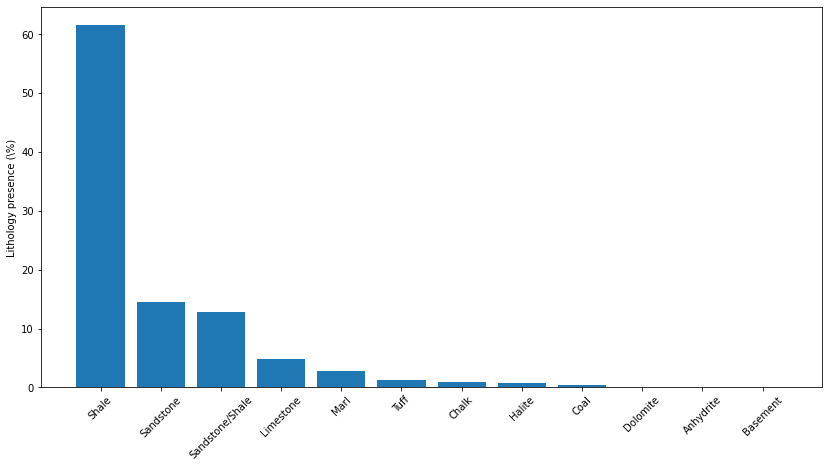

In [9]:
counts = data['FORCE_2020_LITHOFACIES_LITHOLOGY'].value_counts()
names = []
percentage = []
N = data['FORCE_2020_LITHOFACIES_LITHOLOGY'].shape[0]
for item in counts.iteritems():
    names.append(lithology_keys[item[0]])
    percentage.append(float(item[1])/N*100)
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(len(names)), height=percentage)
ax.set_xticklabels(names, rotation=45)
ax.set_xticks(np.arange(len(names)))
ax.set_ylabel('Lithology presence (\%)')

### Missing logs

**Notice that some of the curves are NaN. This is an imporant aspect of this dataset and of this competition.** The only log columns that are **guaranteed** to be present are WELL, DEPT, and GR. All other logs can (and will) be missing from some parts of the dataset.

In [10]:
data.isna().any()

WELL                                 False
DEPTH_MD                             False
X_LOC                                 True
Y_LOC                                 True
Z_LOC                                 True
GROUP                                 True
FORMATION                             True
CALI                                  True
RSHA                                  True
RMED                                  True
RDEP                                  True
RHOB                                  True
GR                                   False
SGR                                   True
NPHI                                  True
PEF                                   True
DTC                                   True
SP                                    True
BS                                    True
ROP                                   True
DTS                                   True
DCAL                                  True
DRHO                                  True
MUDWEIGHT  

In [11]:
data.isna().sum()

WELL                                       0
DEPTH_MD                                   0
X_LOC                                  10775
Y_LOC                                  10775
Z_LOC                                  10775
GROUP                                   1278
FORMATION                             136994
CALI                                   87877
RSHA                                  539861
RMED                                   38993
RDEP                                   11015
RHOB                                  161269
GR                                         0
SGR                                  1101158
NPHI                                  405102
PEF                                   498819
DTC                                    80863
SP                                    306264
BS                                    487854
ROP                                   635440
DTS                                   995898
DCAL                                  871678
DRHO      

The following plot shows how large a percentage of training data wells contain at least some depth interval with the given logs. As you can see a couple of logs like RT and DTS are present in less than half of the training wells. **Remember, the test data will have a similar distribution of available logs**

d:\anaconda3\envs\force\lib\site-packages\ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


Text(0, 0.5, 'Well presence (\\%)')

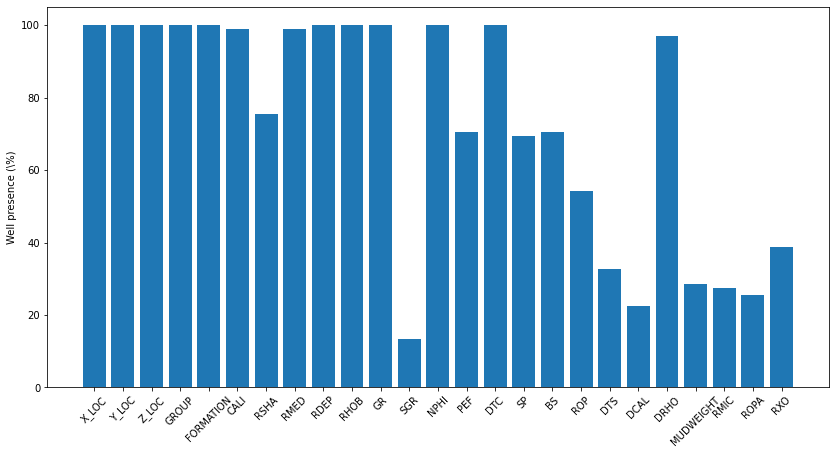

In [13]:
occurences = np.zeros(25)
for well in data['WELL'].unique():
    occurences += data[data['WELL'] == well].isna().all().astype(int).values[2:-2]
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(occurences.shape[0]), height=(data.WELL.unique().shape[0]-occurences)/data.WELL.unique().shape[0]*100.0)
ax.set_xticklabels(data.columns[2:-2], rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Well presence (\%)')

#### Look at some log curves for a couple of wells

(3272.0240000000003, 494.528)

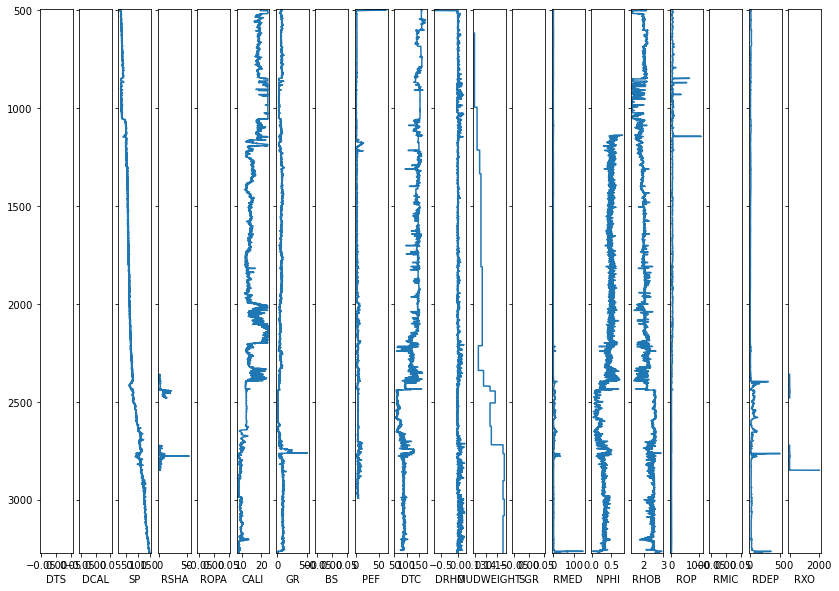

In [15]:
well_data = data[data['WELL'] == wells[0]]
fig, axs = plt.subplots(1, len(well_data.columns)-9, figsize=(14, 10), sharey=True)
for ic, col in enumerate(set(well_data.columns)-set(['DEPTH_MD', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
                                                     'FORCE_2020_LITHOFACIES_CONFIDENCE', 'WELL', 'GROUP', 'FORMATION',
                                                    'X_LOC', 'Y_LOC', 'Z_LOC'])):
    axs[ic].plot(well_data[col], well_data['DEPTH_MD'])
    axs[ic].set_xlabel(col)
axs[0].set_ylim(well_data['DEPTH_MD'].values[-1], well_data['DEPTH_MD'].values[0])

(4422.0172, 2484.1692)

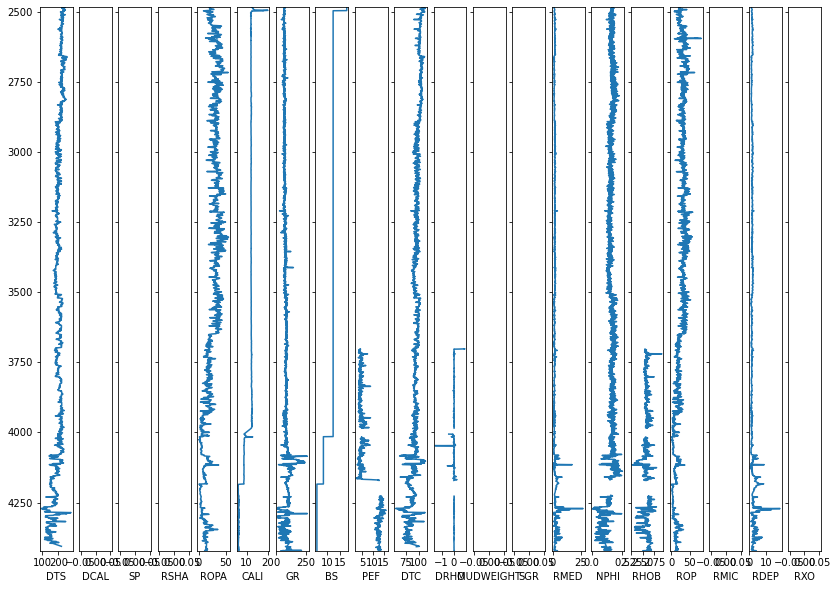

In [18]:
well_data = data[data['WELL'] == wells[57]]
fig, axs = plt.subplots(1, len(well_data.columns)-9, figsize=(14, 10), sharey=True)
for ic, col in enumerate(set(well_data.columns)-set(['DEPTH_MD', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
                                                     'FORCE_2020_LITHOFACIES_CONFIDENCE', 'WELL', 'GROUP', 'FORMATION',
                                                    'X_LOC', 'Y_LOC', 'Z_LOC'])):
    axs[ic].plot(well_data[col], well_data['DEPTH_MD'])
    axs[ic].set_xlabel(col)
axs[0].set_ylim(well_data['DEPTH_MD'].values[-1], well_data['DEPTH_MD'].values[0])

### Preparing data for training

In [19]:
X = data.drop(columns=['WELL', 'FORCE_2020_LITHOFACIES_LITHOLOGY', 'FORCE_2020_LITHOFACIES_CONFIDENCE'])

##### As a simple approach we replace nan with zero and hope for the best

In [20]:
X.fillna(0, inplace=True)

#### We should convert lithology labels to numbers 0-11 before training

In [21]:
y = data['FORCE_2020_LITHOFACIES_LITHOLOGY']

In [22]:
lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}

In [23]:
y = y.map(lithology_numbers)

##### Lithologies are not equally likely. Probably smart to take this into account by computing class weights

In [24]:
np.bincount(y)

array([168937, 150455, 720803,  33329,   1688,  56320,  10513,   8213,
         1085,  15245,   3820,    103], dtype=int64)

##### Shuffle the data

In [25]:
X, y = shuffle(X, y, random_state=42)

In [26]:
X

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,RDEP,...,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO
30423,2343.304000,436806.46875,6463010.5,-2318.007324,ROGALAND GP.,Lista Fm.,14.882113,0.771240,0.771240,0.662699,...,88.208725,12.250001,12.761565,0.000000,2.632109,0.115312,0.143792,0.000000,0.000000,0.57085
1073159,3582.467851,543919.75000,6856653.5,-3477.858154,CROMER KNOLL GP.,Roedby Fm.,8.645628,0.000000,5.599961,4.988578,...,0.000000,8.500000,10.556081,150.206314,0.000000,-0.007215,0.000000,6.627153,10.410796,0.00000
436368,734.814000,483545.34375,6590313.0,-709.762207,NORDLAND GP.,Utsira Fm.,0.000000,0.000000,0.000000,1.000559,...,0.000000,17.500000,109.271744,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
290688,1075.968000,487291.25000,6643945.0,-1053.937988,HORDALAND GP.,0,17.646826,0.000000,0.867609,1.231773,...,21.596836,17.500000,7.970956,0.000000,0.215513,0.051340,0.958611,0.000000,0.000000,0.00000
1118085,3580.061600,537897.75000,6791142.5,-3069.179688,BAAT GP.,Rannoch Fm.,8.572706,0.000000,7.634528,8.066478,...,0.000000,8.500000,31.773550,140.671463,0.000000,0.039784,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,2619.545201,0.00000,0.0,0.000000,ZECHSTEIN GP.,Smith Bank Fm.,12.437759,0.000000,0.000000,0.000000,...,0.000000,12.250001,2.385924,0.000000,0.000000,0.000000,1.425934,0.000000,0.000000,0.00000
259178,3032.057901,476870.34375,6625402.0,-3008.017822,VIKING GP.,Draupne Fm.,12.151999,1.934554,1.315825,1.341654,...,58.382977,12.250001,0.000000,0.000000,-0.098000,0.037645,0.000000,0.000000,0.000000,0.00000
131932,2015.638396,476768.28125,6523588.5,-1989.272949,HEGRE GP.,Skagerrak Fm.,8.527798,0.000000,1.631037,1.619809,...,0.000000,8.500000,9.060954,172.162643,0.000000,-0.001382,0.000000,0.000000,0.000000,0.00000
671155,1424.414000,530753.68750,6732068.0,-1380.430908,ROGALAND GP.,Lista Fm.,0.000000,0.000000,0.000000,0.576554,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


#### Select only the columns you want to use

In [27]:
X.columns

Index(['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION', 'CALI',
       'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF', 'DTC', 'SP',
       'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC', 'ROPA', 'RXO'],
      dtype='object')

In [28]:
X = X[['DEPTH_MD', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS']]

##### Scale the features

In [29]:
scaler = StandardScaler()

In [30]:
X.columns

Index(['DEPTH_MD', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF',
       'DTC', 'SP', 'BS'],
      dtype='object')

In [31]:
X = scaler.fit_transform(X)

##### Split into train and test data

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Applying the custom scoring function

Apart from the missing log curves, **one of the key challenges of this machine learning competition is that you are being scored using a custom scoring function**. 

A prediction is scored using the penalty function
$$ S = - \frac{1}{N}\sum_{i=0}^N A_{ \hat{y}_i y_i} $$
where $N$ is the number of samples, $y_i$ is prediction for sample $i$, $\hat{y}_i$ is the true target for sample $i$, and $A$ is the penalty matrix given by the following

In short, the value of the matrix A at row i and column j is the **penalty** given by guessing lithology number i when the correct label is lithology numner j. Notice that the diagonal consists of zeros, no penalty is given for correct predictions.

In [33]:
A = np.load('penalty_matrix.npy')

In [34]:
A

array([[0.   , 2.   , 3.5  , 3.   , 3.75 , 3.5  , 3.5  , 4.   , 4.   ,
        2.5  , 3.875, 3.25 ],
       [2.   , 0.   , 2.375, 2.75 , 4.   , 3.75 , 3.75 , 3.875, 4.   ,
        3.   , 3.75 , 3.   ],
       [3.5  , 2.375, 0.   , 2.   , 3.5  , 3.5  , 3.75 , 4.   , 4.   ,
        2.75 , 3.25 , 3.   ],
       [3.   , 2.75 , 2.   , 0.   , 2.5  , 2.   , 2.25 , 4.   , 4.   ,
        3.375, 3.75 , 3.25 ],
       [3.75 , 4.   , 3.5  , 2.5  , 0.   , 2.625, 2.875, 3.75 , 3.25 ,
        3.   , 4.   , 3.625],
       [3.5  , 3.75 , 3.5  , 2.   , 2.625, 0.   , 1.375, 4.   , 3.75 ,
        3.5  , 4.   , 3.625],
       [3.5  , 3.75 , 3.75 , 2.25 , 2.875, 1.375, 0.   , 4.   , 3.75 ,
        3.125, 4.   , 3.75 ],
       [4.   , 3.875, 4.   , 4.   , 3.75 , 4.   , 4.   , 0.   , 2.75 ,
        3.75 , 3.75 , 4.   ],
       [4.   , 4.   , 4.   , 4.   , 3.25 , 3.75 , 3.75 , 2.75 , 0.   ,
        4.   , 4.   , 3.875],
       [2.5  , 3.   , 2.75 , 3.375, 3.   , 3.5  , 3.125, 3.75 , 4.   ,
        0.   , 2.5  

The scoring function can be implemented as follows. If used as a loss function in a neural network framwork, it is recommended to implement a more efficient function based on tensor products. 

In [35]:
def score(y_true, y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

**IMPORTANT: The implementation above assumes zero-indexed y_true and y_pred. Be careful not to mix zero-indexed and 1-indexed class labels.**

Let us see what happens when we test the scoring function on some corner cases:

##### Lazily guessing SHALE for everything gives an OK score due to the imbalance of the dataset

In [36]:
score(y_test.values, np.ones(y_test.shape)*2)

-1.154113253567874

##### Doing the same for an uncommon class, like COAL, not so much..

In [37]:
score(y_test.values, np.ones(y_test.shape)*11)

-3.0950906225037698

##### Of course getting it completely right gives the highest possible score, 0

In [38]:
score(y_test.values, y_test.values)

0.0

### Example prediction on open test dataset

##### Train an oversimplified dummy model for the sake of the example
In order to give examples of how to submit predictions and reproducible code, we will train a RandomForestClassifier on the full feature set where we lazily have set all missing values (NaNs) to zero. This is an example only, following along this approach for the competition is not recommended. However, the template below can be used for generating predictions for the weekly leaderboard from your own model, and as an example on how to ecapsulate your model for final scoring where you have to submit code.

Apart from the inherent flaws of the random forest classifier, this example approach has a number of issues and simplifications. For example:
* Data is not separated per well. Normalization and shuffling is done across the whole dataset.
* The penatly matrix is not taken into account, it is treated as a normal classification problem.
* Missing logs are treated as zeros
* Depth and formation tops not taken into account
* Same model is used for when you only have gamma ray logs as when you have the full set of logs

In [39]:
model = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced')

In [40]:
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=50,
                       random_state=42)

#### Test model

In [41]:
y_pred_test = model.predict(X_test)

In [42]:
score(y_test.values, y_pred_test)

-0.12972655198780025

##### Save model and scaler to files

In [43]:
pickle.dump(model, open('model.pkl', 'wb'))

In [44]:
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In order to make it easy to run inference on new data, such as the open test dataset, it is recommended to wrap the initialization of the model, all preprocessing steps including normalization, treatment of NaNs and removals of unused columns in a class or pipeline. There are many ways of doing this, one example being a class like below:

In [45]:
class Model(object):
    def __init__(self, model_file, scaler_file):
        # Load pre-trained model from file
        self.model = pickle.load(open(model_file, 'rb'))
        # Load a "pre-trained" scaler from file
        self.scaler = pickle.load(open(scaler_file, 'rb'))
        
    def _preprocess(self, features):
        # Method to be run before inference. Contains things like
        # stripping unwanted columns, replacing NaNs, and scaling 
        # or normalizing data
        features.fillna(0, inplace=True)
        features = features[['DEPTH_MD', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS']]
        return self.scaler.transform(features)
        
    def predict(self, features):
        # This function should be able to take in features in their
        # raw, unprocessed form as read from the file test.csv and
        # return predictions as an array integers of the same length
        X = self._preprocess(features)
        return self.model.predict(X)

The model can then be initialized using persisted data in the form of saved model file (or models files), scaler files, and other persisted data.  

In [46]:
model = Model('model.pkl', 'scaler.pkl')

##### Example submission: weekly leaderboard
For the weekly leaderboard that will start September 1st, you are asked to submit predictions on the supplied open dataset in the file `test.csv`. This file contains all the columns that are in the training data except LITHOLOGY and LITHOLOGY_CONFIDENCE. Notice that the test data will also have missing columns. It is therefore important that your inference pipeline has the treatment of these missing columns as part of the pre-processing step.

In [47]:
open_test_features = pd.read_csv('test.csv', sep=';')

In [48]:
open_test_features.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO
0,15/9-14,480.628001,423244.50000,6461862.5,-455.624420,NORDLAND GP.,NaN,19.2031,NaN,1.613886,...,35.525719,NaN,96.461990,NaN,NaN,-0.538873,0.130611,NaN,NaN,NaN
1,15/9-14,480.780001,423244.50000,6461862.5,-455.776428,NORDLAND GP.,NaN,19.2031,NaN,1.574376,...,36.158520,NaN,96.454399,NaN,NaN,-0.539232,0.130611,NaN,NaN,NaN
2,15/9-14,480.932001,423244.50000,6461862.5,-455.928436,NORDLAND GP.,NaN,19.2031,NaN,1.436627,...,36.873703,NaN,96.446686,NaN,NaN,-0.540830,0.130611,NaN,NaN,NaN
3,15/9-14,481.084001,423244.50000,6461862.5,-456.080444,NORDLAND GP.,NaN,19.2031,NaN,1.276094,...,37.304054,NaN,161.170166,NaN,NaN,-0.543943,0.130611,NaN,NaN,NaN
4,15/9-14,481.236001,423244.53125,6461862.5,-456.232422,NORDLAND GP.,NaN,19.2031,NaN,1.204704,...,37.864922,NaN,172.489120,NaN,NaN,-0.542104,0.130611,NaN,NaN,NaN


In [49]:
open_test_features.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF',
       'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC',
       'ROPA', 'RXO'],
      dtype='object')

In [50]:
test_prediction = model.predict(open_test_features)

In [51]:
test_prediction

array([2, 2, 2, ..., 0, 0, 0], dtype=int64)

**Important:** Before submitting we must map these predictions back to the lithology labels

In [52]:
category_to_lithology = {y:x for x,y in lithology_numbers.items()}

In [55]:
test_prediction_for_submission = np.vectorize(category_to_lithology.get)(test_prediction)

For submission to the weekly leaderboard, write the predictions as a csv file
- single column (no index column or similar)
- header: 'lithology'
- exactly the same number of rows as the raw test features
- use the original lithology labels, 65000, 30000, ..., NOT the encoded ones 0, 1, 2, ...

Example:
```
# lithology
65000
65000
30000
30000
30000
30000
30000
65030
65030
65030
.
.
.
```

In [56]:
test_prediction_for_submission

array([65000, 65000, 65000, ..., 30000, 30000, 30000])

In [57]:
np.savetxt('test_predictions.csv', test_prediction_for_submission, header='lithology', fmt='%i')

### Submitting code for final scoring
At the end of the competition, the highest performing teams are invited to submit code for blind scoring on a hidden test dataset. The winner will be the team with the best score on the hidden test dataset, not the weekly leaderboard. In order to do this, you must submit the following in a zip-file:
* Code to do the inference
* Any persisted data in the form of pre-trained model or models, scalers, and more
* Information about your environment

There are many ways of doing this. In the example above, the code to do the inference would be the `Model` class in a python-file, the persisted data would be the files `model.pkl` and `scaler.pkl`. 

Your python environment needs to be replicable by the judges of the competition. There are many ways of doing this. Examples include dumping pip package versions to a file

In [101]:
!pip freeze > requirements.txt

If you are using Anaconda, then you can export an envionment file as follows

In [103]:
!conda env export > environment.yml

Other options include `Docker`, `pipenv` and many more.